In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from keras.models import Model
from keras.applications import  ResNet50V2
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
#Reading and Shuffling csv that contain filenames and label
df1 = pd.read_csv("/content/drive/Shareddrives/A&D co./BD/Database/labels_new.csv")
from sklearn.utils import shuffle
df2 = shuffle(df1, random_state = 15)
df2.reset_index(inplace=True, drop=True)

In [ ]:
#Constants
num_classes = 3
epochs = 50
IMAGE_SHAPE = (64, 64, 3)
model_name = "ResNet50V2_"
data_dir = "/content/drive/Shareddrives/A&D co./BD/Database/Total_masks"
checkpoint_filepath = "/content/drive/Shareddrives/A&D co./BD/Database/results/ResNet50/"

# **Plotting function of Confusion Matrix**


In [ ]:
def plot_cm(y_true, y_pred,t, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '%.1f%%\n%d' % (0, 0)
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    map = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    a = map.get_figure()
    a.savefig(checkpoint_filepath + model_name + str(batch_sizes[t])+"_"+ str(val_acc[t])+".png")

# **ResNet Model**
Loaded from Keras Api


In [ ]:
def create_ResNet50():
    # load ResNet50 with random init weights.
    model = ResNet50V2(input_shape=IMAGE_SHAPE,weights = None)
    # remove the last fully connected layer
    model.layers.pop()
    output = Dense(num_classes, activation="softmax")
    # connect that dense layer to the model
    output = output(model.layers[-1].output)
    model = Model(inputs=model.inputs, outputs=output)
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy' ])
                                                                                                      
    return model

#**Training with Hypertuning**



In [ ]:
image_generator  = ImageDataGenerator()  
batch_sizes = [32,64,128]
training_data, validate_data, testing_data = np.split(df1.sample(frac=1, random_state=15), [int(.65*len(df1)), int(.8*len(df1))])

val_acc = []

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)


In [ ]:
for i in range(len(batch_sizes)):
  batch_size = batch_sizes[i] 
  train_generator  = image_generator.flow_from_dataframe(training_data,directory = data_dir, batch_size=batch_size,
                                                        x_col = "filename", y_col = "label", target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        class_mode = "categorical", shuffle=True)

  validation_generator = image_generator.flow_from_dataframe(validate_data,directory = data_dir, batch_size=batch_size, 
                                                        x_col = "filename", y_col = "label", target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                                                        class_mode = "categorical", shuffle=True)
  model = create_ResNet50()
  steps_epoch = np.ceil(train_generator.samples/batch_size)
  steps_val = np.ceil(validation_generator.samples/batch_size)
  history = model.fit_generator(train_generator, steps_per_epoch = steps_epoch,
                              validation_data=validation_generator, validation_steps= steps_val, 
                            epochs=epochs, verbose=1, callbacks = [checkpoint])
  
  val_acc.append(np.max(history.history['val_accuracy']))
  
  d = {'validation loss':history.history['val_loss'],'validation accuracy':history.history['val_accuracy'], 'epochs':list(range(1,epochs+1))}
  data =  pd.DataFrame(d)
  data.to_csv( checkpoint_filepath+ model_name+str(batch_sizes[i])+"_"+ str(val_acc[i])+'.csv', index=False)


t = val_acc.index(max(val_acc))  
print('The best validation accuracy of ' + str(val_acc[t]))
print('The best batch size ' + str(batch_sizes[t]))


Found 3473 validated image filenames belonging to 3 classes.
Found 802 validated image filenames belonging to 3 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
109/109 [==============================] - 24s 219ms/step - loss: 1.0548 - accuracy: 0.5269 - auc: 0.7113 - val_loss: 1.1013 - val_accuracy: 0.3678 - val_auc: 0.5256
Epoch 2/50
109/109 [==============================] - 22s 198ms/step - loss: 0.9751 - accuracy: 0.6156 - auc: 0.7999 - val_loss: 1.0415 - val_accuracy: 0.4751 - val_auc: 0.6477
Epoch 3/50
109/109 [==============================] - 22s 198ms/step - loss: 0.9588 - accuracy: 0.5923 - auc: 0.7699 - val_loss: 0.9838 - val_accuracy: 0.5224 - val_auc: 0.7072
Epoch 4/50
109/109 [==============================] - 20s 181ms/step - loss: 0.9002 - accuracy: 0.6237 - auc: 0.8136 - val_loss: 1.1071 - val_accuracy: 0.3815 - val_auc: 0.5481
Epoch 5/50
109/109 [==============================] - 21s 192ms/step - loss: 0.8623 - accuracy:

#**Testing the trained model**

In [ ]:
model_test = create_ResNet50()
model_test.load_weights(checkpoint_filepath)

In [ ]:
test_generator = image_generator.flow_from_dataframe(
                testing_data, 
                data_dir, 
                batch_size=1,
                x_col='filename',
                y_col='label',
                target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
                class_mode='categorical',
                shuffle = False,
                )

Found 1069 validated image filenames belonging to 3 classes.


In [ ]:
model_test.evaluate(test_generator)

1069/1069 [==============================] - 13s 12ms/step - loss: 0.3732 - accuracy: 0.8887 - auc: 0.9574


[0.37318548560142517, 0.8886809945106506, 0.9573925733566284]

In [ ]:
#From Prob to Int; from Int to Str
index_to_cls = {v: k for k, v in test_generator.class_indices.items()}
Y_pred = model_test.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_pred_st = np.vectorize(index_to_cls.get)(y_pred)
y_true = np.vectorize(index_to_cls.get)(test_generator.classes)

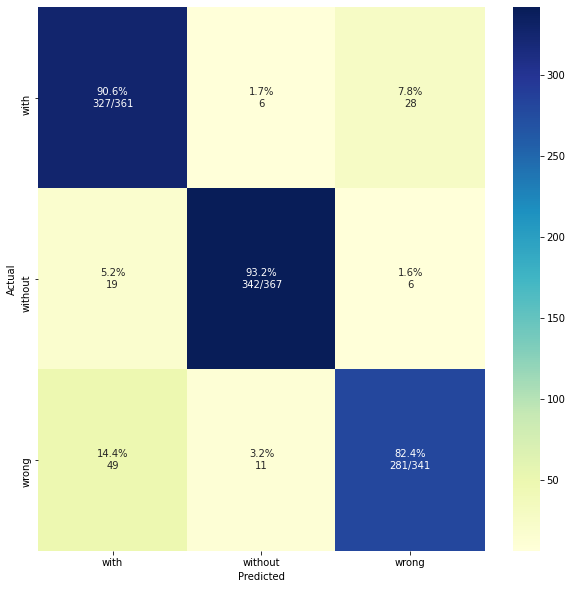

In [ ]:
plot_cm(y_true, y_pred_st,t)

In [ ]:

plot_model(model_test, show_shapes=True, expand_nested=False,
show_layer_names=True)

In [ ]:
model_test.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 34, 34, 64)   0           conv1_conv[0][0]                 
_______________________________________________________________________________________